In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [2]:
# Import data
df_data = pd.read_csv('data/data.csv')

# Define numpy arrays of data
J = df_data['J [mm/h]'].to_numpy()
#Q = df_data['Q [mm/h]'].to_numpy()
#ET = df_data['ET [mm/h]'].to_numpy()

Cin = df_data['Cin [-]']

# Create spinup
J_w_spinup = J
Cin_w_spinup = Cin

num_spinup_repeat = 2  # how many times is the timeseries repeated in front of data

for j in range(num_spinup_repeat):
    J_w_spinup = np.concatenate((J_w_spinup, J))
    Cin_w_spinup = np.concatenate((Cin_w_spinup, Cin))

In [3]:
# Define model parameters
S_u_ref = 100
S_l_ref = 2000
b_u = 10
b_l = 20
nu = 0.5

P_bar = np.mean(J)

In [4]:
# Initialize hydrological components
orig_data_len = len(J)
max_data_len = len(J_w_spinup)
spinup_len = max_data_len - orig_data_len

S_u = np.zeros(max_data_len + 1)
S_l = np.zeros_like(S_u)

L = np.zeros(max_data_len)
Q_l = np.zeros_like(L)
Q_s = np.zeros_like(L)

S_u[0] = S_u_ref
S_l[0] = S_l_ref

In [5]:
# Initialize WTT distributions
# time steps to save
time_steps_to_save = np.array([35065, spinup_len, max_data_len-2])
p_S_u = np.zeros([len(time_steps_to_save), max_data_len])
p_S_l = np.zeros_like(p_S_u)
p_Q_l = np.zeros_like(p_S_u) #np.zeros([len(J),2*len(J)]) for full convolution
p_Q_s = np.zeros_like(p_S_u)

norm_L = np.zeros_like(L)
norm_Q_l = np.zeros_like(L)

## Hydrologic model and streamflow concentration simulations

**Hydrologic model with (some) TTD computations**

In [ ]:
for j in range(max_data_len-1):
    ## Hydrological model
    # upper box
    L[j] = P_bar * (S_u[j] / S_u_ref)**b_u
    S_u[j+1] = S_u[j] + J_w_spinup[j] - L[j]

    # lower box
    Q_l[j] = (1 - nu) * P_bar * (S_l[j] / S_l_ref)**b_l
    S_l[j+1] = S_l[j] + (1-nu) * L[j] - Q_l[j]

    # stream discharge
    Q_s[j] = nu * L[j] + Q_l[j]

    # prepare normalised outflows
    norm_L[j] = L[j] / S_u[j]
    norm_Q_l[j] = Q_l[j] / S_l[j]
    
    ## Water Age balance
    # upper box
    if j in time_steps_to_save:
        # set index
        k = np.array(np.where(time_steps_to_save == j)).item()
        
        p_S_u[k,:j+1] = (J_w_spinup[j::-1] / S_u[j]) * np.exp(-np.cumsum(norm_L[j::-1]))

        # lower box
        
        p_S_l[k,:j+1] = ((1 - nu) * L[j::-1] / S_l[j]) * np.exp(-np.cumsum(norm_Q_l[j::-1]))
        p_Q_l[k,:j+1] = scipy.signal.convolve(p_S_l[k,:j+1], p_S_u[k,:j+1], mode='full', method='fft')[:(j+1)]
        #p_Q_l[j,:(2*(j+1)-1)] = scipy.signal.convolve(p_S_l[j,:j+1], p_S_u[j,:j+1], mode='full', method='fft')

        # streamflow age
        p_Q_s[k,:j+1] = nu * L[j] / (nu * L[j] + Q_l[j]) * p_S_u[k,:j+1] + Q_l[j] / (nu * L[j] + Q_l[j]) * p_Q_l[k,:j+1]


**Streamflow concentration simulation**

In [ ]:
# Initialize discharge concentration
Cout = np.zeros(orig_data_len)

for j in range(max_data_len-1):
    ## Hydrological model
    # upper box
    L[j] = P_bar * (S_u[j] / S_u_ref)**b_u
    S_u[j+1] = S_u[j] + J_w_spinup[j] - L[j]

    # lower box
    Q_l[j] = (1 - nu) * P_bar * (S_l[j] / S_l_ref)**b_l
    S_l[j+1] = S_l[j] + (1-nu) * L[j] - Q_l[j]

    # stream discharge
    Q_s[j] = nu * L[j] + Q_l[j]

    # prepare normalised outflows
    norm_L[j] = L[j] / S_u[j]
    norm_Q_l[j] = Q_l[j] / S_l[j]
    
    ## Water Age balance
    
    if j >= (spinup_len - 1):
        # upper box
        p_S_u_temp = (J_w_spinup[j::-1] / S_u[j]) * np.exp(-np.cumsum(norm_L[j::-1]))

        # lower box
        p_S_l_temp = ((1 - nu) * L[j::-1] / S_l[j]) * np.exp(-np.cumsum(norm_Q_l[j::-1]))  # age since entry in lower box
        p_Q_l_temp = scipy.signal.convolve(p_S_l_temp, p_S_u_temp, mode='full', method='fft')[:(j + 1)]

        # streamflow age
        p_Q_s_temp = nu * L[j] / (nu * L[j] + Q_l[j]) * p_S_u_temp + Q_l[j] / (nu * L[j] + Q_l[j]) * p_Q_l_temp

        # streamflow concentration
        Cout[j - spinup_len] = np.sum(Cin_w_spinup[j::-1] * p_Q_s_temp) / np.sum(p_Q_s_temp)


**Streamflow concentration simulation with both original and compressed Cin and p_S**

In [7]:
# Age class division: geometric progression properties
a = 12  # scale factor
r = 2  # common ratio
n = np.floor(np.emath.logn(r, len(J_w_spinup)/a + 1)) - 1 # number of terms

# Geometric series (sum of the geometric progression's terms)
# Also serves as age threshold in raw TTD
T_thresh = int(a * (1 - r**n) / (1 - r))

# Compute index position for averaging in compressed TTD
ind_p_S_var_step = np.arange(a)

for j in range(1, int(n)):
    temp_ind = np.arange(np.max(ind_p_S_var_step) + 1, (j+1) * a)
    temp_ind = np.repeat(temp_ind, r**j)
    ind_p_S_var_step = np.concatenate((ind_p_S_var_step, temp_ind))

# Bincount for compressed TTD
bincount = np.bincount(ind_p_S_var_step)

# Initialize tresholded raw TTD
p_Q_s_temp_tresh = np.zeros(T_thresh)

# Initialize age class TTD
p_Q_s_var_step = np.zeros([orig_data_len, a * int(n)])

# Initialize discharge concentration
Cout = np.zeros(orig_data_len)

def find_xi(a_, r_, i_):
    xi_ = a_ * (1 - r_**(i_ // a_)) / (1 - r_) + (i_ % a_) * r_**(i_ // a_)
    return int(xi_)

Cout_comp = np.zeros(orig_data_len)

# Reverse the input concentration array (double spinup), assumes spinup period is longer than original time series
Cin_w_spinup_reversed = np.flip(Cin_w_spinup)

# Initialize reversed and compressed input concentration array for storing values at each timestep
Cin_w_spinup_rev_comp = np.zeros([orig_data_len, a * int(n)])

# Precompute xi values with correct size (concentration timestep entering/leaving each bin (age class) relative to t)
xi_indices = np.array([find_xi(a, r, i) for i in range(a * int(n) + 1)])

for j in range(max_data_len):
    ## Hydrological model
    # upper box
    L[j] = P_bar * (S_u[j] / S_u_ref)**b_u
    S_u[j+1] = S_u[j] + J_w_spinup[j] - L[j]

    # lower box
    Q_l[j] = (1 - nu) * P_bar * (S_l[j] / S_l_ref)**b_l
    S_l[j+1] = S_l[j] + (1 - nu) * L[j] - Q_l[j]

    # stream discharge
    Q_s[j] = nu * L[j] + Q_l[j]

    # prepare normalised outflows
    norm_L[j] = L[j] / S_u[j]
    norm_Q_l[j] = Q_l[j] / S_l[j]
    
    ## Water Age balance
    
    if j >= (spinup_len):
        # upper box
        p_S_u_temp = (J_w_spinup[j::-1] / S_u[j]) * np.exp(-np.cumsum(norm_L[j::-1]))

        # lower box
        p_S_l_temp = ((1 - nu) * L[j::-1] / S_l[j]) * np.exp(-np.cumsum(norm_Q_l[j::-1]))  # age since entry in lower box
        p_Q_l_temp = scipy.signal.convolve(p_S_l_temp, p_S_u_temp, mode='full', method='fft')[:(j + 1)]

        # streamflow age
        p_Q_s_temp = nu * L[j] / (nu * L[j] + Q_l[j]) * p_S_u_temp + Q_l[j] / (nu * L[j] + Q_l[j]) * p_Q_l_temp

        # Thresholding the end of TTD array
        if j <= T_thresh:
            p_Q_s_temp_tresh[:j] = p_Q_s_temp
        else:
            p_Q_s_temp_tresh[:T_thresh-1] = p_Q_s_temp[:T_thresh-1]
            p_Q_s_temp_tresh[T_thresh-1] = np.sum(p_Q_s_temp[T_thresh:])

        # Compute compressed TTD
        p_Q_s_var_step[j - spinup_len, :] = np.bincount(ind_p_S_var_step, weights=p_Q_s_temp_tresh) / bincount

        # Streamflow concentration
        
        Cout[j - spinup_len] = np.sum(Cin_w_spinup[j::-1] * p_Q_s_temp) / np.sum(p_Q_s_temp)

        # Compute indices of entering/leaving bins (age classes) input concentration values w.r.t. global C_in_w_spinup_reversed array
        Ci_indices = max_data_len - j + xi_indices
        
        # Compute weighted differences between entering and leaving input concentration in each bin/age class
        Ci_diff = Cin_w_spinup_reversed[Ci_indices[:-1]] / r**(np.arange(a * n) // a) - Cin_w_spinup_reversed[Ci_indices[1:]] / r**(np.arange(a * n) // a)

        
        if j == (spinup_len):
            # Initialize first compressed input concentration at time t=0
            Cin_w_spinup_rev_comp[0, :] = (
                np.bincount(ind_p_S_var_step, weights=Cin_w_spinup_reversed[orig_data_len:orig_data_len+T_thresh])
                / bincount
                )

            # Compute first output concentration at time t=0
            Cout_comp[0] = np.sum(Cin_w_spinup_rev_comp[0, :] * p_Q_s_var_step[0, :] * bincount) / np.sum(p_Q_s_var_step[0, :] * bincount)
        else:
            # Update compressed concentrations by adding the entering/leaving concentration difference to each bin of the previous timestep
            Cin_w_spinup_rev_comp[j - spinup_len, :] = Cin_w_spinup_rev_comp[j - spinup_len - 1, :] + Ci_diff

            # Compute compressed output concentration
            Cout_comp[j - spinup_len] = np.sum(Cin_w_spinup_rev_comp[j - spinup_len, :] * p_Q_s_var_step[j - spinup_len, :] * bincount) / np.sum(p_Q_s_var_step[j - spinup_len, :] * bincount)

**Streamflow concentration simulation with compressed Cin and p_S, comp only, opt p_S**

In [6]:
## Run hydrological model
for j in range(max_data_len):
    
    # upper box
    L[j] = P_bar * (S_u[j] / S_u_ref)**b_u
    S_u[j+1] = S_u[j] + J_w_spinup[j] - L[j]

    # lower box
    Q_l[j] = (1 - nu) * P_bar * (S_l[j] / S_l_ref)**b_l
    S_l[j+1] = S_l[j] + (1 - nu) * L[j] - Q_l[j]

    # stream discharge
    Q_s[j] = nu * L[j] + Q_l[j]

    # prepare normalised outflows
    norm_L[j] = L[j] / S_u[j]
    norm_Q_l[j] = Q_l[j] / S_l[j]
    
# Age class division: geometric progression properties
a = 12  # scale factor
r = 2  # common ratio
n = np.floor(np.emath.logn(r, len(J_w_spinup)/a + 1)) - 1 # number of terms

# Geometric series (sum of the geometric progression's terms)
# Also serves as age threshold in raw TTD
T_thresh = int(a * (1 - r**n) / (1 - r))

# Compute index position for averaging in compressed TTD
ind_p_S_var_step = np.arange(a)

for j in range(1, int(n)):
    temp_ind = np.arange(np.max(ind_p_S_var_step) + 1, (j+1) * a)
    temp_ind = np.repeat(temp_ind, r**j)
    ind_p_S_var_step = np.concatenate((ind_p_S_var_step, temp_ind))

# Bincount for compressed TTD
bincount = np.bincount(ind_p_S_var_step)

# Initialize tresholded raw TTD
p_Q_s_temp_tresh = np.zeros(T_thresh)

# Initialize age class TTD
p_Q_s_var_step = np.zeros([orig_data_len, a * int(n)])

def find_xi(a_, r_, i_):
    xi_ = a_ * (1 - r_**(i_ // a_)) / (1 - r_) + (i_ % a_) * r_**(i_ // a_)
    return int(xi_)

Cout_comp_opt = np.zeros(orig_data_len)

# Reverse the input concentration array (double spinup), assumes spinup period is longer than original time series
Cin_w_spinup_reversed = np.flip(Cin_w_spinup)

# Initialize reversed and compressed input concentration array for storing values at each timestep
Cin_w_spinup_rev_comp = np.zeros([orig_data_len, a * int(n)])

# Precompute xi values with correct size (concentration timestep entering/leaving each bin (age class) relative to t)
xi_indices = np.array([find_xi(a, r, i) for i in range(a * int(n) + 1)])

# Pre-compute cumsum
cumsum_norm_L = np.cumsum(norm_L[::-1])
cumsum_norm_Q_l = np.cumsum(norm_Q_l[::-1])


for j in range(spinup_len, max_data_len):
    ## Water Age balance
    # upper box
    p_S_u_temp = (
        (J_w_spinup[j::-1] / S_u[j]) 
        * np.exp(norm_L[j] + cumsum_norm_L[max_data_len-j] - cumsum_norm_L[max_data_len-j-1:])
    )

    # lower box
    p_S_l_temp = (
        ((1 - nu) * L[j::-1] / S_l[j]) 
        * np.exp(norm_Q_l[j] + cumsum_norm_Q_l[max_data_len-j] - cumsum_norm_Q_l[max_data_len-j-1:])
        )  # age since entry in lower box
    p_Q_l_temp = scipy.signal.convolve(p_S_l_temp, p_S_u_temp, mode='full', method='fft')[:(j + 1)]

    # streamflow age
    p_Q_s_temp = nu * L[j] / (nu * L[j] + Q_l[j]) * p_S_u_temp + Q_l[j] / (nu * L[j] + Q_l[j]) * p_Q_l_temp

    # Thresholding the end of TTD array
    if j <= T_thresh:
        p_Q_s_temp_tresh[:j] = p_Q_s_temp
    else:
        p_Q_s_temp_tresh[:T_thresh-1] = p_Q_s_temp[:T_thresh-1]
        p_Q_s_temp_tresh[T_thresh-1] = np.sum(p_Q_s_temp[T_thresh:])

    # Compute compressed TTD
    p_Q_s_var_step[j - spinup_len, :] = np.bincount(ind_p_S_var_step, weights=p_Q_s_temp_tresh) / bincount


    ## Streamflow concentration
    
    # Compute indices of entering/leaving bins (age classes) input concentration values w.r.t. global C_in_w_spinup_reversed array
    Ci_indices = max_data_len - j + xi_indices
    
    # Compute weighted differences between entering and leaving input concentration in each bin/age class
    Ci_diff = (
        Cin_w_spinup_reversed[Ci_indices[:-1]] / r**(np.arange(a * n) // a) 
        - Cin_w_spinup_reversed[Ci_indices[1:]] / r**(np.arange(a * n) // a)
    )

    
    if j == (spinup_len):
        # Initialize first compressed input concentration at time t=0
        Cin_w_spinup_rev_comp[0, :] = (
            np.bincount(ind_p_S_var_step, weights=Cin_w_spinup_reversed[orig_data_len:orig_data_len+T_thresh])
            / bincount
            )

        # Compute first output concentration at time t=0
        Cout_comp_opt[0] = np.sum(Cin_w_spinup_rev_comp[0, :] * p_Q_s_var_step[0, :] * bincount) / np.sum(p_Q_s_var_step[0, :] * bincount)
    else:
        # Update compressed concentrations by adding the entering/leaving concentration difference to each bin of the previous timestep
        Cin_w_spinup_rev_comp[j - spinup_len, :] = Cin_w_spinup_rev_comp[j - spinup_len - 1, :] + Ci_diff

        # Compute compressed output concentration
        Cout_comp_opt[j - spinup_len] = (
            np.sum(Cin_w_spinup_rev_comp[j - spinup_len, :] * p_Q_s_var_step[j - spinup_len, :] * bincount) 
            / np.sum(p_Q_s_var_step[j - spinup_len, :] * bincount)
        )

In [ ]:
# steady-state mean transit time
print(f"Steady-state mean transit time: {round(S_u_ref / P_bar / 24, 2)} days in the upper box"
      f" and {round(S_l_ref / ((1-n)*P_bar) / 24, 2)} days in the lower box\n"
      f"Steady-state mean transit time: {round((S_u_ref + S_l_ref) / P_bar / 24, 2)} days in the combined discharge")

# hydraulic response timescale
print(f"Hydraulic response timescale: {round(S_u_ref / (b_u*P_bar) / 24, 2)} days in the upper box"
      f" and {round(S_l_ref / (b_l*(1-n)*P_bar) / 24, 2)} days in the lower box")

In [ ]:
# Plot age distributions
fig, axs = plt.subplots(2, 2, figsize=(14, 9))

axs[0,0].plot(p_S_u[2, :len(J)])
axs[0,0].set_title('Upper box storage')

axs[0,1].plot(p_S_l[2, :len(J_w_spinup)])
axs[0,1].set_title('Lower box storage (age since entry in lower box)')

axs[1,0].plot(p_Q_l[2, :len(J_w_spinup)])
axs[1,0].set_title('Lower box discharge (convolution)')

axs[1,1].plot(p_Q_s[2, :len(J)])
axs[1,1].set_title('Overall stream discharge')

fig.suptitle('System age distributions');

In [ ]:
# Plot hydrologic system
fig, axs = plt.subplots(2, 2, figsize=(9, 9))

axs[1,0].plot(S_l)
axs[1,0].set_title('Lower box storage')

axs[0,0].plot(S_u)
axs[0,0].set_title('Upper box storage')

#axs[0,1].plot(n*L)
axs[0,1].plot(Q_l)
axs[0,1].set_title('Lower box discharge')

axs[1,1].plot(Q_s)
axs[1,1].set_title('Overall stream discharge')

fig.suptitle('Hydrologic system');

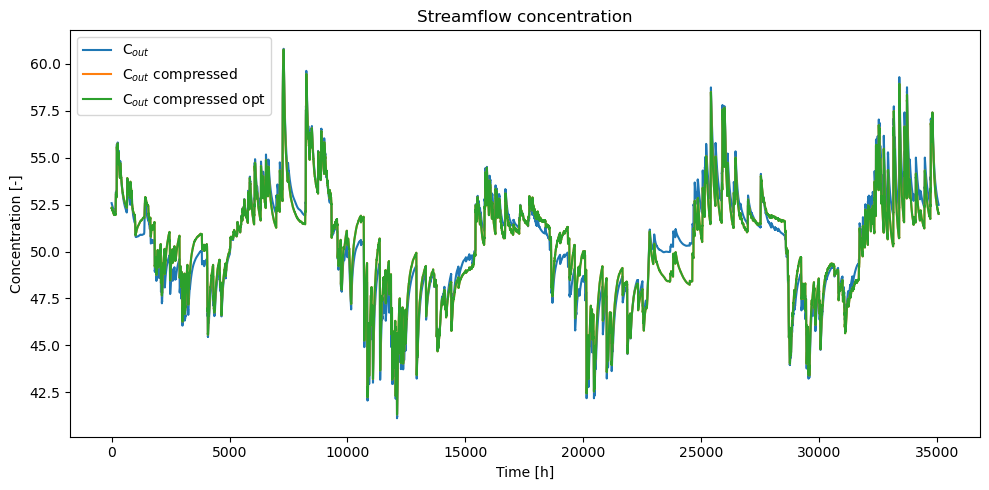

In [8]:
fig, ax = plt.subplots(figsize=(10,5))

#ax.plot(Cin, label='C$_{in}$')
ax.plot(Cout, label='C$_{out}$')
ax.plot(Cout_comp, label='C$_{out}$ compressed')
ax.plot(Cout_comp_opt, label='C$_{out}$ compressed opt')

ax.set_xlabel('Time [h]')
ax.set_ylabel('Concentration [-]')
ax.set_title('Streamflow concentration')
ax.legend()

fig.tight_layout();


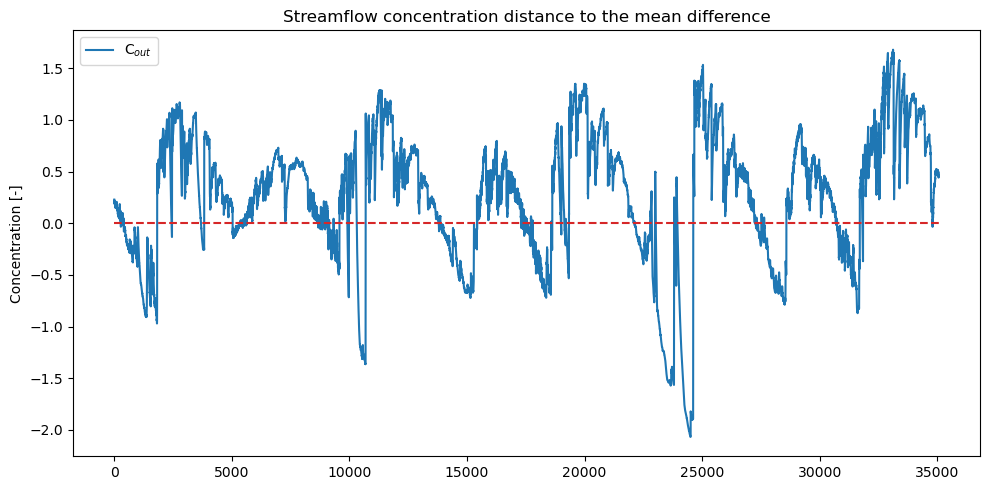

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

# ax.plot(np.abs(Cout_comp - np.mean(Cout_comp)), label='C$_{out}$')
# ax.plot(np.abs(Cout - np.mean(Cout)), label='C$_{out}$')
ax.plot(np.abs(Cout - np.mean(Cout)) - np.abs(Cout_comp - np.mean(Cout_comp)), label='C$_{out}$')
ax.hlines(xmin=0, xmax=len(Cout), y=0, colors='tab:red', linestyles='dashed')

ax.set_ylabel('Concentration [-]')
ax.set_title('Streamflow concentration distance to the mean difference')
ax.legend()

fig.tight_layout();

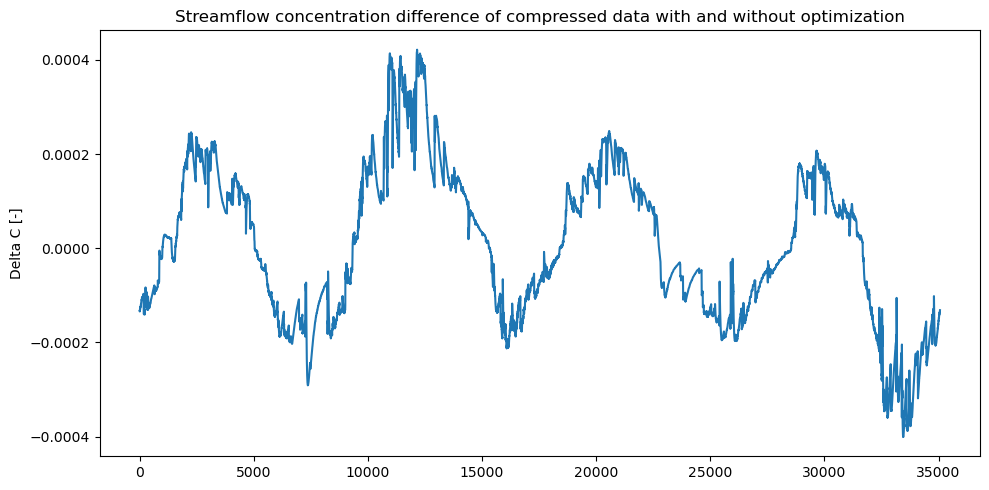

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(Cout_comp_opt - Cout_comp)

ax.set_ylabel('Delta C [-]')
ax.set_title('Streamflow concentration difference of compressed data with and without optimization')

fig.tight_layout();